<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages-import" data-toc-modified-id="Packages-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages import</a></span></li><li><span><a href="#Read-train/test-datasets" data-toc-modified-id="Read-train/test-datasets-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read train/test datasets</a></span></li><li><span><a href="#Define-your-Keras-model-using-Transfer-Learning" data-toc-modified-id="Define-your-Keras-model-using-Transfer-Learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define your Keras model using Transfer Learning</a></span></li><li><span><a href="#Model-compiler" data-toc-modified-id="Model-compiler-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model compiler</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#Train/validation-error-history" data-toc-modified-id="Train/validation-error-history-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train/validation error history</a></span></li><li><span><a href="#Performance-on-test-dataset" data-toc-modified-id="Performance-on-test-dataset-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Performance on test dataset</a></span></li><li><span><a href="#1st-interpretation" data-toc-modified-id="1st-interpretation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>1st interpretation</a></span></li><li><span><a href="#2nd-interpretation" data-toc-modified-id="2nd-interpretation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>2nd interpretation</a></span></li></ul></div>

### Packages import

In [1]:
# Import base packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import DL packages
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')
import tensorflow_hub as hub
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

TensorFlow version: 2.3.1
Keras version: 2.4.0


### Read train/test datasets
Create a function to read train and test datasets with follow actions:
- Have a look at readme.txt from the unzipped folder to get more information about the datasets
- Columns should be renamed to 'rate' and 'text'
- Take a random sample of 5000 records for training and test datasets
- Positive labels should be mapped to 0 (instead of 2 in the initial dataset)

In [13]:
def read_format_dataset(dataset_path):
    df = pd.read_csv(dataset_path, names=['rate', 'text'], sep=',',nrows=5000)
    df['rate'].loc[df['rate'] == 2] = 0
    return df

train_dataset_path = 'data/yelp_review_polarity_csv/train.csv'
test_dataset_path = 'data/yelp_review_polarity_csv/test.csv'
train_data = read_format_dataset(train_dataset_path)
test_data = read_format_dataset(test_dataset_path)
train_data.head()

,rate,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,0,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,0,All the food is great here. But the best thing...


### Define your Keras model using Transfer Learning
Now you should define your NN structure using Keras sequential layers. Your base model will come from TensorFlow Hub with source url https://tfhub.dev/google/universal-sentence-encoder/4.
To import this base model in your structure, you must use hub.KerasLayer function (https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). You should add following parameters:
- input_shape = []
- dtype = tf.string
- trainable = False

Please note this trainable option that allows to retrain the entire NN or not.

Now that you have your base model, you should add a new layer on top to predict a probability for our 2 classes (Positive/Negative). Which layer would you use for this ? Which activation function ?

Your final model should have two layers:
- base model with 256797824 params
- prediction layer with 513 params

Please have a look at the number of training params and its relation with base model option trainable.

In [34]:
model_use4 ="https://tfhub.dev/google/universal-sentence-encoder/4" 
model = tf.keras.Sequential([
                        hub.KerasLayer(model_use4, input_shape = [], dtype = tf.string, trainable = False),
        Dense(1,activation ='sigmoid')   
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


### Model compiler
Compile your Keras model using an Adam optimizer, binary crossentropy for the loss and accuracy as the target metric

In [35]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics="accuracy")

### Model training
Split your training data into x_train, x_valid, y_train, y_valid using sklearn function. Test size must be set to 0.3 and the repartition of the target variable should be similar between your valid and training samples.

In [36]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data['text'],train_data['rate'], test_size=0.3, random_state=42)

Now you can train your NN by providing your training and valid datasets. Number of epochs can be set to 5 for now. You need to save the model fit output into history variable, so we can plot the loss later.

In [37]:
y_valid.shape

(1500,)

In [38]:
history = model.fit(x=x_train, y=  y_train, validation_data =(x_valid,y_valid),epochs=5)

Epoch 1/5
110/110 [==============================] - 9s 82ms/step - loss: 0.6649 - accuracy: 0.7246 - val_loss: 0.6357 - val_accuracy: 0.8060
Epoch 2/5
110/110 [==============================] - 7s 62ms/step - loss: 0.6127 - accuracy: 0.8300 - val_loss: 0.5899 - val_accuracy: 0.8387
Epoch 3/5
110/110 [==============================] - 7s 63ms/step - loss: 0.5704 - accuracy: 0.8414 - val_loss: 0.5526 - val_accuracy: 0.8420
Epoch 4/5
110/110 [==============================] - 7s 63ms/step - loss: 0.5356 - accuracy: 0.8480 - val_loss: 0.5212 - val_accuracy: 0.8493
Epoch 5/5
110/110 [==============================] - 7s 65ms/step - loss: 0.5068 - accuracy: 0.8523 - val_loss: 0.4951 - val_accuracy: 0.8533


### Train/validation error history
You can plot the training/validation error and accuracy using the following function.

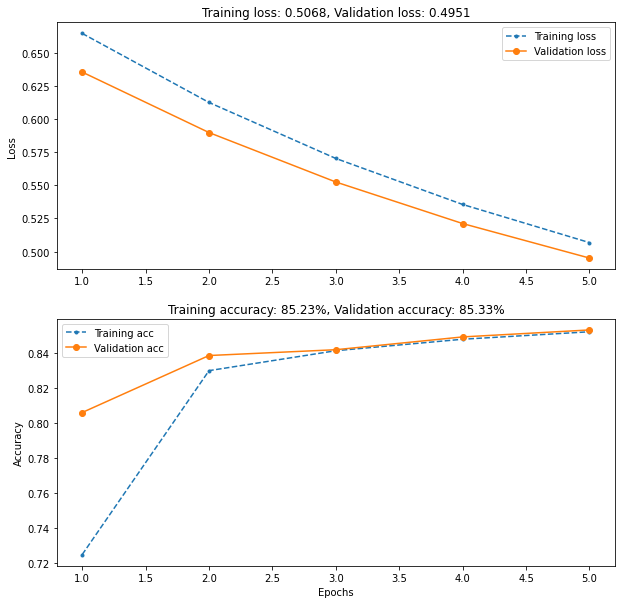

In [39]:
def plot_loss_acc(history):
    """Plot training and (optionally) validation loss and accuracy"""

    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 10))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, '.--', label='Training loss')
    final_loss = loss[-1]
    title = 'Training loss: {:.4f}'.format(final_loss)
    plt.ylabel('Loss')
    if 'val_loss' in history.history:
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, 'o-', label='Validation loss')
        final_val_loss = val_loss[-1]
        title += ', Validation loss: {:.4f}'.format(final_val_loss)
    plt.title(title)
    plt.legend()

    acc = history.history['accuracy']

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, '.--', label='Training acc')
    final_acc = acc[-1]
    title = 'Training accuracy: {:.2f}%'.format(final_acc * 100)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    if 'val_accuracy' in history.history:
        val_acc = history.history['val_accuracy']
        plt.plot(epochs, val_acc, 'o-', label='Validation acc')
        final_val_acc = val_acc[-1]
        title += ', Validation accuracy: {:.2f}%'.format(final_val_acc * 100)
    plt.title(title)
    plt.legend()

plot_loss_acc(history)

### Performance on test dataset
Compute the accuracy for our test dataset

In [45]:
y_pred = model.predict_classes(test_data['text'])
acc=accuracy_score(test_data['rate'], y_pred)
print(acc)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


0.8486


### 1st interpretation
Apart from the final precision, what do you think about the training/validation curves ? Is there any evidence of overfitting when we freeze the base layer ?

Now, you can go back to the model definition and unfreeze our base layers. You should see the difference with the number of trainable parameters. No other parameters should be updated. Obviously training your model will take longer.

### 2nd interpretation
What do you notice now with our training/validation curves? Do you have any hints about why we observe such results ?

You need to find a way to solve this problem. Please go back to the model definition and try to add new type of layer.